In [1]:
# Visualize the optimization process

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torchvision import datasets, transforms

/home/asifahm/.conda/envs/ece4420/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/asifahm/.conda/envs/ece4420/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Hyperparameters
input_size = 784
output_size = 10
num_epochs = 30
batch_size = 64
learning_rate = 0.001
collect_every_n_epochs = 3

In [5]:
# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

In [6]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, output_size)

    def forward(self, x):
        x = x.view(-1, input_size)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
# Initialize model
model = Model().to(device)

In [9]:
print(model.parameters)
# total_params = sum(p.numel() for p in model.parameters())
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

<bound method Module.parameters of Model(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)>
39760


In [10]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# Function to collect and flatten weights
def collect_weights(model, layer_idx=None):
    if layer_idx is not None:
        # Collect weights from a specific layer
        layer_weights = list(model.parameters())[layer_idx].cpu().detach().numpy().flatten()
    else:
        # Collect all weights from the model
        all_weights = [param.cpu().detach().numpy().flatten() for param in model.parameters()]
        layer_weights = np.concatenate(all_weights)
    return layer_weights

In [12]:
# Train the model 8 times
layer_weights_collection = []
model_weights_collection = []

for run in range(8):
    print(f"Training for run: {run+1}/{8}")
    # Initialize model
    model = Model().to(device)

    layer_weights_run = []
    model_weights_run = []

    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # Collect weights every 3 epochs
        if (epoch + 1) % 3 == 0:
            # Collect from fc1 layer (index 0)
            layer_weights_run.append(collect_weights(model, layer_idx=0))
            # Collect from the entire model
            model_weights_run.append(collect_weights(model))

    layer_weights_collection.append(layer_weights_run)
    model_weights_collection.append(model_weights_run)



Training for run: 1/8
Training for run: 2/8
Training for run: 3/8
Training for run: 4/8
Training for run: 5/8
Training for run: 6/8
Training for run: 7/8
Training for run: 8/8


In [13]:
print(f"layer_weights_collection.shape: {len(layer_weights_collection)}")
print(layer_weights_collection)
print(f"model_weights_collection.shape: {len(model_weights_collection)}")

layer_weights_collection.shape: 8
[[array([-0.0190311 ,  0.02771812, -0.03133537, ...,  0.01587179,
       -0.01275046,  0.01327731], dtype=float32), array([-0.0190311 ,  0.02771812, -0.03133537, ...,  0.01587179,
       -0.01275046,  0.01327731], dtype=float32), array([-0.0190311 ,  0.02771812, -0.03133537, ...,  0.01587179,
       -0.01275046,  0.01327731], dtype=float32), array([-0.0190311 ,  0.02771812, -0.03133537, ...,  0.01587179,
       -0.01275046,  0.01327731], dtype=float32), array([-0.0190311 ,  0.02771812, -0.03133537, ...,  0.01587179,
       -0.01275046,  0.01327731], dtype=float32), array([-0.0190311 ,  0.02771812, -0.03133537, ...,  0.01587179,
       -0.01275046,  0.01327731], dtype=float32), array([-0.0190311 ,  0.02771812, -0.03133537, ...,  0.01587179,
       -0.01275046,  0.01327731], dtype=float32), array([-0.0190311 ,  0.02771812, -0.03133537, ...,  0.01587179,
       -0.01275046,  0.01327731], dtype=float32), array([-0.0190311 ,  0.02771812, -0.03133537, ...,  

In [16]:
# Function to apply PCA and plot
def plot_pca(weight_collections, title):
    plt.figure(figsize=(8, 6))
    for run_idx, weights in enumerate(weight_collections):
        # Stack weights collected across epochs
        weights_stacked = np.stack(weights)
        pca = PCA(n_components=2)
        weights_pca = pca.fit_transform(weights_stacked)

        # Plot PCA-reduced weights for each run
        plt.scatter(weights_pca[:, 0], weights_pca[:, 1], label=f'Run {run_idx + 1}')

    plt.title(title)
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    # plt.legend()
    plt.show()

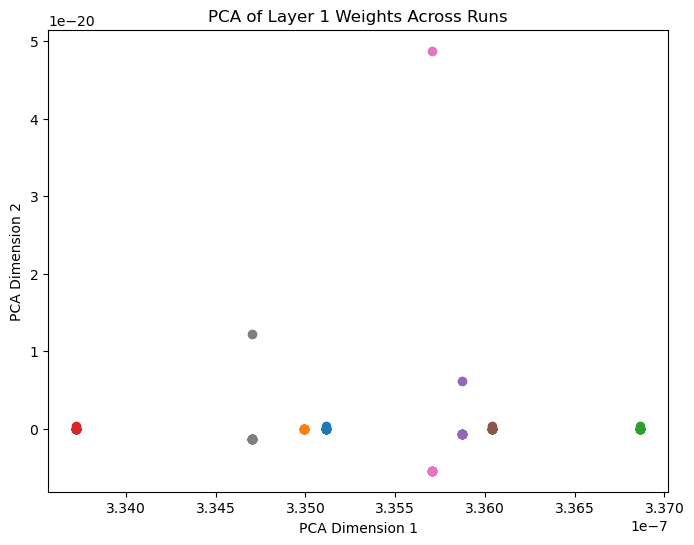

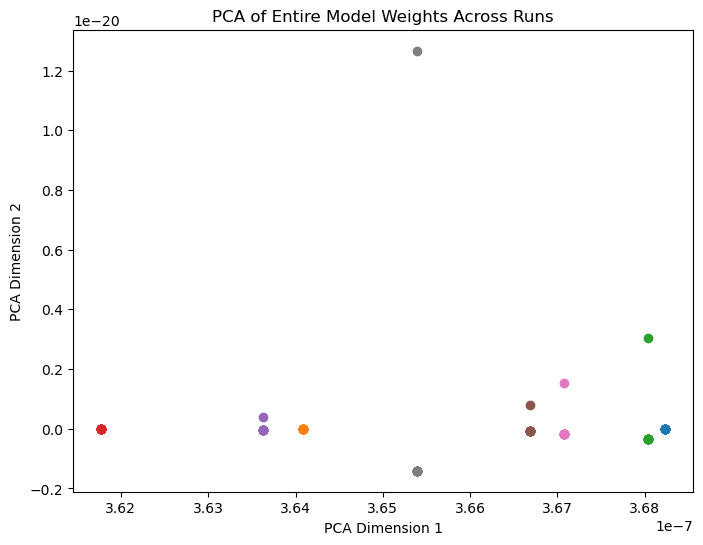

In [18]:
# Plot for the selected layer
plot_pca(layer_weights_collection, "PCA of Layer 1 Weights Across Runs")

# Plot for the entire model
plot_pca(model_weights_collection, "PCA of Entire Model Weights Across Runs")